In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

8468


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    print(dapi_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[0::4], microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )

## Watershed

In [8]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed


In [12]:
%%time
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file)
    
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[::4], microscope_params)

    # Prepare watershed
    print(f"- run watershed")
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.593s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.164s.
-- corrected illumination for channel 405 in 4.203s.
- Finished illumination correction in 8.56

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.496s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.190s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 8.663s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\waters

- Loaded images for channels:['561', '405'] in 5.607s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.156s.
-- corrected illumination for channel 405 in 4.190s.
- Finished illumination correction in 8.677s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_15.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_16.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_016.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_016.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\202

-- corrected illumination for channel 561 in 4.130s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 8.510s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_22.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_23.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_023.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_023.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_023.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.520s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumina

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_29.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_30.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_030.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_030.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_030.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.855s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_37.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_037.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.597s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.186s.
-- corrected illumination for channel 405 in 4.220s.
- Finished illumination correction in 8.5

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_044.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_044.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_044.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.558s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.174s.
-- corrected illumination for channel 405 in 4.188s.
- Finished illumination correction in 8.439s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\waters

- Loaded images for channels:['561', '405'] in 5.014s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.201s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 8.499s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_51.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_52.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_052.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_052.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\202

-- corrected illumination for channel 561 in 4.181s.
-- corrected illumination for channel 405 in 4.189s.
- Finished illumination correction in 8.479s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_58.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_59.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_059.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_059.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_059.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.460s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumina

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_65.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_66.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_066.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.360s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_73.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_073.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_073.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_073.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.584s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.171s.
-- corrected illumination for channel 405 in 4.175s.
- Finished illumination correction in 8.5

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_080.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.597s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.188s.
-- corrected illumination for channel 405 in 4.189s.
- Finished illumination correction in 8.552s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_80.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_81.npy
\\10.245.74.158\Chromatin_NAS_0\20

- Loaded images for channels:['561', '405'] in 3.716s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.196s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 8.542s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_87.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_88.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_088.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_088.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\202

-- corrected illumination for channel 561 in 4.185s.
-- corrected illumination for channel 405 in 4.236s.
- Finished illumination correction in 8.567s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_94.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_95.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_095.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_095.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_095.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.755s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumina

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_101.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_102.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_102.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_102.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_102.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.491s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- correct

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_109.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_109.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_109.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_109.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.569s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.200s.
-- corrected illumination for channel 405 in 4.188s.
- Finished illumination correction in 8.

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_116.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_116.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_116.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.507s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.171s.
-- corrected illumination for channel 405 in 4.224s.
- Finished illumination correction in 8.504s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\waters

- Loaded images for channels:['561', '405'] in 3.533s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.189s.
-- corrected illumination for channel 405 in 4.189s.
- Finished illumination correction in 8.472s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_123.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_124.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_124.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_124.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\2

-- corrected illumination for channel 561 in 4.175s.
-- corrected illumination for channel 405 in 4.207s.
- Finished illumination correction in 8.476s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_130.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_131.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.077s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumi

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_137.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_138.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_138.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_138.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_138.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.576s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- correct

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_145.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_145.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_145.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_145.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.081s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.193s.
-- corrected illumination for channel 405 in 4.216s.
- Finished illumination correction in 8.

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_152.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 3.634s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.201s.
-- corrected illumination for channel 405 in 4.203s.
- Finished illumination correction in 8.595s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\waters

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_159.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['561', '405'] in 4.264s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.173s.
-- corrected illumination for channel 405 in 4.175s.
- Finished illumination correction in 8.489s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_159.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_160.npy
\\10.245.74.158\Chromatin_NAS_0\

- Loaded images for channels:['561', '405'] in 4.316s.
- Correct illumination for channels: ['561', '405']
-- Keep channels: ['561', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 561 in 4.232s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 8.671s.
- run watershed
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_166.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_167.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_167.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_167.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\2

## Check result

<IPython.core.display.Javascript object>


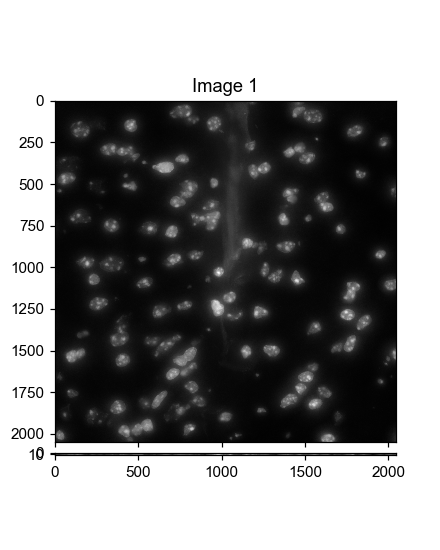

In [17]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405[::4], polyt_im, corr_labels3d, new_labels])